This repository contains a workflow for time-series forecasting of water quality variables in Manawatu Catchment, New Zealand. I have applied Autorregressive Intergrated Moving Average technique to forecast the variables of interest. The data used spans 25 years with monthly observations recorded.

TOOLS APPLIED
====================
statsmodel, numpy, pandas, matplolib, sklearn, pmdarima

RESULTS
====================
The resulting models are qualified using Root Mean Square Error (RMSE) and Mean Square Error (MSE). The predictions are also plotted along with their corresponding observed values. The result show good fit for water quality variables prediction.

# IMPORT REQUIRED PACKAGES

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima


from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


import warnings
warnings.filterwarnings("ignore")

# LOAD DATA

In [55]:
data_dir = "Manawatu_site_WA7NOV2020.csv"

In [56]:
df = pd.read_csv(data_dir, index_col = 'Date', parse_dates= True)
print('The number of rows in tne data are', len(df))

The number of rows in tne data are 300


In [57]:
df.head()

,Site,Month,Year,Time,Temp,DO_PERCENT,DO_ppm,Flow,Clar,Turb,pH,EC,NH4,NO3,TN,DRP,TP,Abs
Date,,,,,,,,,,,,,,,,,,
1989-01-25,WA7,Jan,1989,12:15,20.0,102.2,9.1,1.78,1.00,1.80,8.68,292.0,9,12,195.0,1.0,16,15
1989-02-21,WA7,Feb,1989,9:30,19.8,91.8,8.2,2.22,1.50,2.40,8.31,273.0,15,7,170.0,2.0,16,20
1989-03-22,WA7,Mar,1989,13:15,14.3,114.3,11.6,2.18,2.75,1.20,8.52,270.0,5,7,135.0,1.0,11,13
1989-04-19,WA7,Apr,1989,11:45,15.4,101.5,9.9,1.28,3.65,0.72,8.38,333.0,3,8,185.0,1.0,9,13
1989-05-17,WA7,May,1989,13:00,12.2,104.0,10.9,4.11,1.90,1.50,8.28,289.0,7,200,385.0,3.0,24,20


# VARIABLES MEANING
DO_PERCENT:
DO_ppm: Dissolved oxygen in parts per million <br>
Flow: Flow of the river<br>
Clar: Clarity (water transparency) <br>
Turb: Turbidity<br>
pH: pH value <br>
EC: Electrical conductivity<br>
NH4: Ammonium <br>
NO3: Nitrate<br>
TN: Total nitrogen<br>
DRP: Dissolved reactive phosphorus<br>
TP: Total phosphorus<br>
Abs: Absorbance<br>

# EXPLORATORY DATA ANALYSIS

In [70]:
variables_to_model = df.columns.tolist()[4:]

In [71]:
len(variables_to_model)

14

## Time series plots

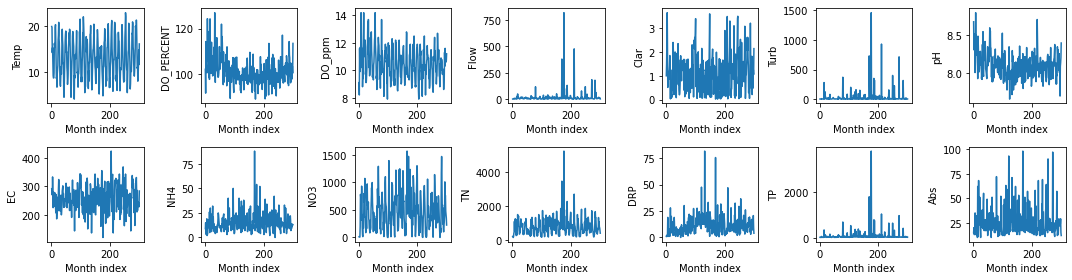

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(15,4))
for i, ax in enumerate(axes.flat):
    var = variables_to_model[i]
    ax.plot(list(range(1,len(df)+1)), df[var])
    ax.set_ylabel(var)
    ax.set_xlabel('Month index')

fig.tight_layout()

Observations from time series plots 
- All the data variables are of different scale. Hence, data standardization will be required in the case of multivariate analysis. However, this work presents a univariate analysis and thus will not require data standardization.
- Some of the variables show certain levels of correlation. This correlation will be further explored in subsequent cells.
- There are some outlier data points (time points) in variables like TN, Flow, TP, Turb, NH4. This will also be explored in the cell immediately below.

## Box plot
The box plot below shows the description (Min, Max, Median, Mean and outliers) for each observed variable

In [73]:
df_variables = df.drop(['Site', 'Month', 'Year', 'Time'], axis=1)

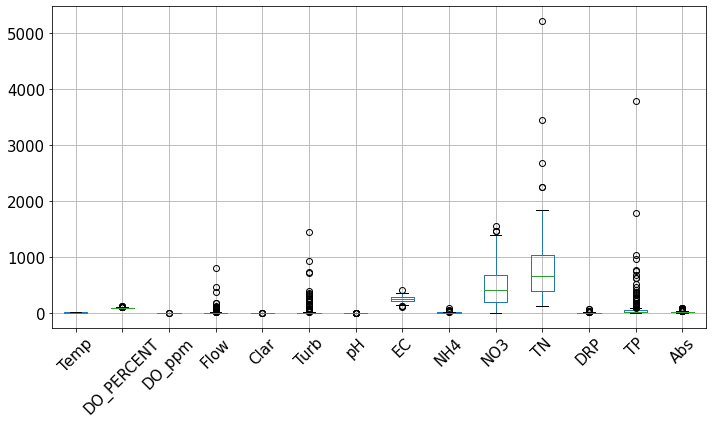

In [74]:
df_variables.boxplot(figsize=(10,6), rot=45, fontsize=15)
plt.tight_layout()

## Correlation analysis

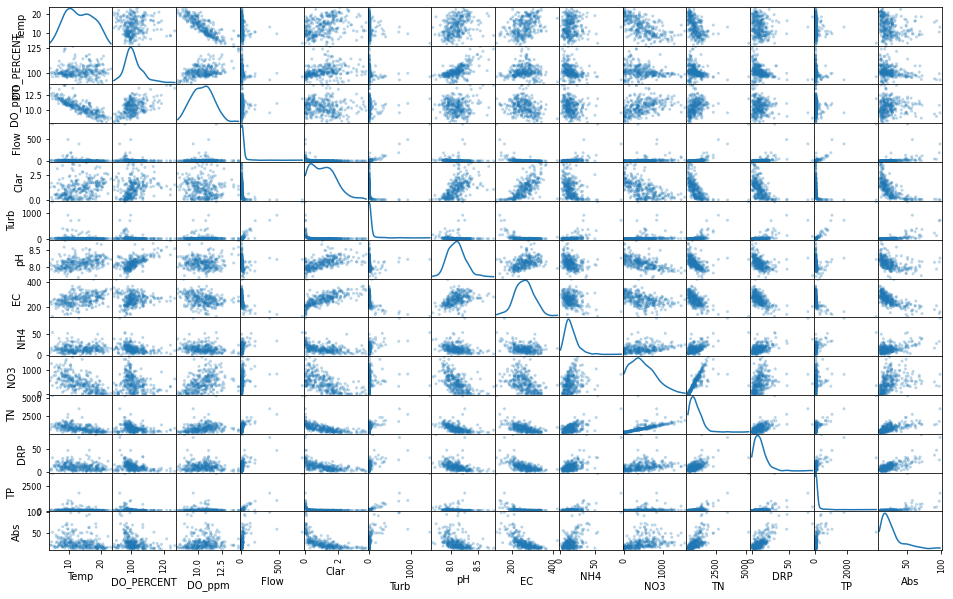

In [75]:
pd.plotting.scatter_matrix(df_variables, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

<AxesSubplot:>

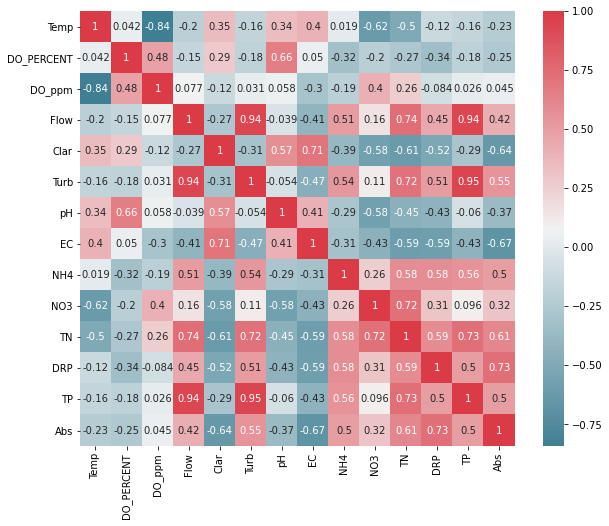

In [76]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_variables.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

Observations from the correlation analysis:. 
- TP, FLOW, Turb are highly correlated variables with correlation coefficient above 0.94. In cases like this, these signals can be averages into a single representative signal which can then be regressed. However, for the purpose of this work, which is simply exploratory, we have not applied this technique. In line with water quality literature, Flow, TP (Total phosphorous) and Turb (Turbidity) are related variables, hence the resulting high correlation values are as expected.

## Seasonal decomposition to explore trend, seasonality and residual in the data.

For this analysis, I have chosen DO_ppm, NH4, DO_PERCENT, EC which do not show any strong correlation with other observed variables. 

### Seasonal decomposition of DO_ppm 

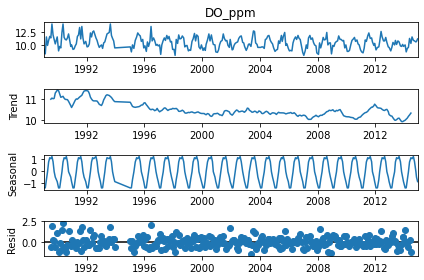

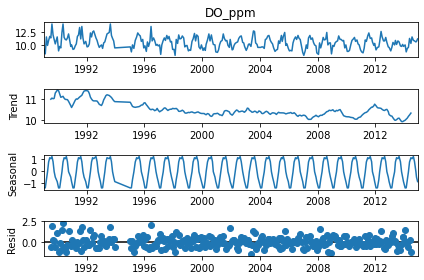

In [77]:
do_ppm_decomposition = seasonal_decompose(df['DO_ppm'], model = 'add', period=12)
do_ppm_decomposition.plot()

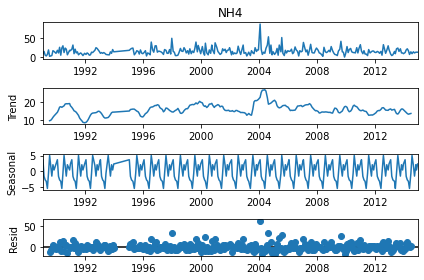

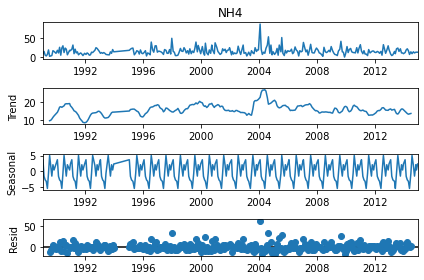

In [78]:
nh4_decomposition = seasonal_decompose(df['NH4'], model = 'add', period=12)
nh4_decomposition.plot()

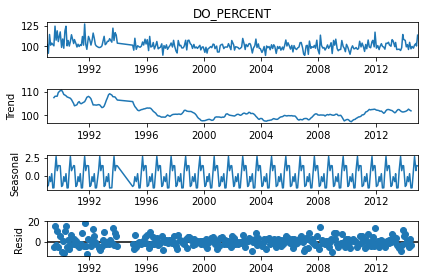

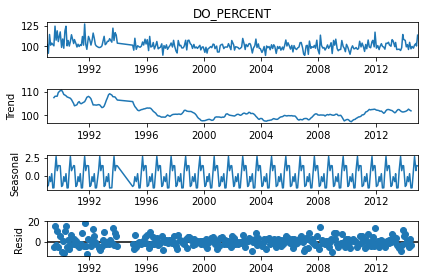

In [94]:
do_percent_decomposition = seasonal_decompose(df['DO_PERCENT'], model = 'add', period=12)
do_percent_decomposition.plot()

Results from seasonal decomposition:
- It can be observed that seasonality is strong is all the three selected variables. This is expected since water quality is affected runoff variability, for exmaple it is less in the dry season and more in the wet season.


# DATA SPLIT

For this task, I chose 1 year as my forecast period, i.e data from the forst 24 years is used to forecast the final 1 year. The presented technique can also be used to forecasty more years

In [80]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]
pred = {}

# MODELING WITH SARIMA (Seasonal ARIMA)

For this analysis, I have chosen DO_ppm,DO_PERCENT which do not show any strong correlation with other observed variables as the variables to model.

PROCESS:
- Search for best model params using auto arima. The best model is the one with least Akaike Information Criterion (AIC)
- Use resulting best model params to fit model and regress data

### DO_ppm

In [81]:
auto_do_ppm = auto_arima(df['DO_ppm'], seasonal = True, m=6)
auto_do_ppm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  300
Model:             SARIMAX(5, 1, 0)x(2, 0, [1, 2], 6)   Log Likelihood                -337.368
Date:                                Wed, 03 Mar 2021   AIC                            694.735
Time:                                        01:51:34   BIC                            731.740
Sample:                                             0   HQIC                           709.546
                                                - 300                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9774      0.029    -33.158      0.000      -1.035      -0.920
ar.L2         -0.9341      0.042    -22.211      0.000      -1.016      -0.852
ar.L3         -0.8845      0.056    -15.888      0.000      -0.994      -0.775
ar.L4         -0.9213      0.052    -17.858      0.000      -1.022      -0.820
ar.L5         -0.8866      0.051    -17.268      0.000      -0.987      -0.786
ar.S.L6       -1.0227      0.118     -8.700      0.000      -1.253      -0.792
ar.S.L12      -0.0263      0.115     -0.228      0.820      -0.253       0.200
ma.S.L6        0.0865      0.100      0.866      0.387      -0.109       0.282
ma.S.L12      -0.7434      0.071    -10.434      0.000      -0.883      -0.604
sigma2         0.5307      0.045     11.690      0.000       0.442       0.620
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                20.50
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Result of auto arima param search:

As seen above, the best parameters for the SARIMAX(p, d, q)(P, D, Q) model is (5, 1, 0)x(2, 0, [1, 2], 6). These parameters will be used to fit the SARIMA model which is used in this work.

In [82]:
model = SARIMAX(train['DO_ppm'], order=(5,1,0), seasonal_order=(2,0,[1,2],6))
do_ppm_train = model.fit()
do_ppm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                 DO_ppm   No. Observations:                  288
Model:             SARIMAX(5, 1, 0)x(2, 0, [1, 2], 6)   Log Likelihood                -322.122
Date:                                Wed, 03 Mar 2021   AIC                            664.244
Time:                                        01:51:36   BIC                            700.839
Sample:                                             0   HQIC                           678.911
                                                - 288                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9841      0.032    -30.887      0.000      -1.047      -0.922
ar.L2         -0.9508      0.044    -21.737      0.000      -1.037      -0.865
ar.L3         -0.8755      0.061    -14.350      0.000      -0.995      -0.756
ar.L4         -0.9015      0.060    -15.029      0.000      -1.019      -0.784
ar.L5         -0.8568      0.061    -14.114      0.000      -0.976      -0.738
ar.S.L6       -1.0360      0.117     -8.822      0.000      -1.266      -0.806
ar.S.L12      -0.0375      0.116     -0.323      0.746      -0.265       0.190
ma.S.L6        0.1369      0.109      1.254      0.210      -0.077       0.351
ma.S.L12      -0.7450      0.080     -9.309      0.000      -0.902      -0.588
sigma2         0.5190      0.047     11.085      0.000       0.427       0.611
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                16.73
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
start = len(train)
end = len(train)+len(test)-1
pred_do_ppm = do_ppm_train.predict(start=start, end=end, dynamic = False, typ= 'level')
pred['DO_ppm'] = pred_do_ppm.tolist()

### TEMP

In [84]:
auto_temp = auto_arima(df['Temp'], seasonal = True, m=6)
auto_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  300
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 6)   Log Likelihood                -649.217
Date:                           Wed, 03 Mar 2021   AIC                           1308.434
Time:                                   01:51:40   BIC                           1326.953
Sample:                                        0   HQIC                          1315.845
                                           - 300                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.7294      1.214      7.192      0.000       6.350      11.109
ar.L1          0.2419      0.064      3.774      0.000       0.116       0.368
ar.S.L6       -0.3666      0.054     -6.747      0.000      -0.473      -0.260
ar.S.L12       0.5013      0.052      9.667      0.000       0.400       0.603
sigma2         4.3185      0.382     11.310      0.000       3.570       5.067
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.98   Prob(JB):                         0.37
Heteroskedasticity (H):               1.17   Skew:                            -0.15
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
model = SARIMAX(train['Temp'], order=(1,0,0), seasonal_order=(2,0,0,6))
temp_train = model.fit()
temp_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              Temp   No. Observations:                  288
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 6)   Log Likelihood                -679.411
Date:                           Wed, 03 Mar 2021   AIC                           1366.821
Time:                                   01:51:40   BIC                           1381.473
Sample:                                        0   HQIC                          1372.693
                                           - 288                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9792      0.012     79.374      0.000       0.955       1.003
ar.S.L6       -0.2577      0.056     -4.625      0.000      -0.367      -0.149
ar.S.L12       0.3760      0.058      6.431      0.000       0.261       0.491
sigma2         6.4137      0.626     10.251      0.000       5.187       7.640
===================================================================================
Ljung-Box (L1) (Q):                  20.40   Jarque-Bera (JB):                 4.11
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               1.11   Skew:                             0.13
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
start = len(train)
end = len(train)+len(test)-1
pred_temp = temp_train.predict(start=start, end=end, dynamic = False, typ= 'level')
pred['Temp'] = pred_temp.tolist()

In [87]:
variables_modeled = ['DO_ppm', 'Temp']
lenght_of_test = len(test)

# PLOT PREDICTED RESULTS

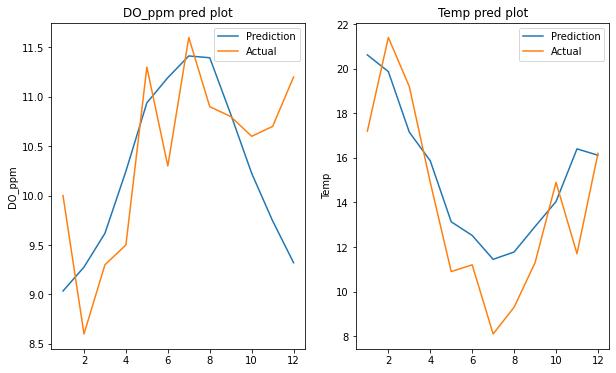

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=len(variables_modeled), figsize=(10, 6))

for i, ax in enumerate(axes):
    var = variables_modeled[i]
    ax.plot(list(range(1,lenght_of_test+1)), pred[var], label='Prediction')
    ax.plot(list(range(1,lenght_of_test+1)), test[var], label='Actual')
    ax.set_ylabel(var)
    ax.set_title(var+' pred plot')
    ax.legend()

# DERIVE ERROR VALUES

In [89]:
from sklearn.metrics import mean_squared_error

In [90]:
temp_error = mean_squared_error(test['Temp'], pred['Temp'], squared=True)
do_ppm_error = mean_squared_error(test['DO_ppm'], pred['DO_ppm'], squared=True)

temp_error_2 = mean_squared_error(test['Temp'], pred['Temp'], squared=False)
do_ppm_error_2 = mean_squared_error(test['DO_ppm'], pred['DO_ppm'], squared=False)

<BarContainer object of 2 artists>

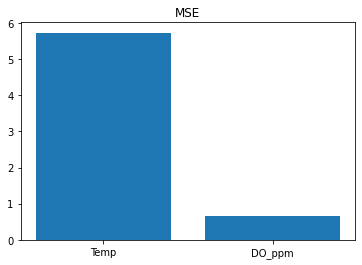

In [91]:
plt.title('MSE')
plt.bar(height=[temp_error, do_ppm_error], x=['Temp', 'DO_ppm'])

<BarContainer object of 2 artists>

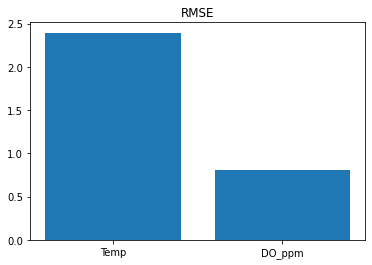

In [92]:
plt.title('RMSE')
plt.bar(height=[temp_error_2, do_ppm_error_2], x=['Temp', 'DO_ppm'])